**Importowanie danych, przygotowanie cech modelu Random Forest, trening modelu(In-Sample)**

W tej części pobieram dane historyczne, obliczam wskaźniki techniczne i przygotowuję zbiór treningowy (In-Sample) obejmujący rok 2023.
Trenowany jest model Random Forest (200 drzew, głębokość 5), który uczy się przewidywać kierunek rynku następnego dnia (1-wzrost, 0-spadek). Model wykorzystuje sztywne cechy wejściowe: średnie wykładnicze (EMA 10, 20), filtr trendu (SMA 50), RSI, zwroty oraz wolumen.
Proces ten odbywa się wyłącznie na danych historycznych



In [1]:
!pip install yfinance backtesting scikit-learn pandas tqdm scikit-optimize


import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from sklearn.ensemble import RandomForestClassifier


# Pobranie danych

data = yf.download("MSFT", start="2023-01-01", end="2024-05-20", multi_level_index=False, progress=False)

def prepare_features(df):
    df = df.copy()
    # Wskaźniki techniczne
    df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
    df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()

    # Filtr trendu
    df['SMA_50'] = df['Close'].rolling(window=50).mean()

    # RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Zmiana wolumenu i zwroty
    df['Vol_Change'] = df['Volume'].pct_change()
    df['Returns'] = df['Close'].pct_change()

    # Target (1 jeśli cena jutro wzrośnie, 0 jeśli spadnie)
    df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

    return df.dropna(), ['EMA_10', 'EMA_20', 'SMA_50', 'RSI', 'Returns', 'Vol_Change']

df_processed, features = prepare_features(data)


# Trening modelu na danych z 2023
train_data = df_processed[df_processed.index < '2024-01-01']

rf = RandomForestClassifier(random_state=42, n_estimators=200, min_samples_split=10, max_depth=5)
rf.fit(train_data[features], train_data['Target'])

# Predykcja na całym zbiorze
df_processed['Prediction'] = rf.predict(df_processed[features])
probs = rf.predict_proba(df_processed[features])
df_processed['Proba_Up'] = probs[:, 1]
df_processed['Proba_Down'] = probs[:, 0]

#Przygotowanie danych testowych
bt_data = df_processed[(df_processed.index >= '2024-01-01') & (df_processed.index <= '2024-05-06')]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.1/192.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.5 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '
/tmp/ipython-input-810024749.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("MSFT", start="2023-01-01", end="2024-05-20", multi_level_index=False, progress=False)


**Sekcja 2: Definicja Strategii (Klasa SmartTrendStrategy)**

Strategia łączy sygnały techniczne z predykcjami AI. Pozycja długa (Long) otwierana jest, gdy nastąpi przecięcie szybkiej średniej (EMA n1) nad wolną średnią (EMA n2) LUB gdy model AI wskaże wzrost z wysokim prawdopodobieństwem.
Analogicznie, pozycja krótka (Short) otwierana jest przy odwrotnym przecięciu średnich LUB sygnale spadkowym z AI.
Kluczowym warunkiem wejścia jest zgodność z filtrem trendu (cena musi być powyżej/poniżej średniej SMA n_trend). Strategia posiada wbudowane mechanizmy ochrony kapitału: Stop Loss i Take Profit. Parametry średnich (n1, n2, n_trend) nie są tu ustalone na sztywno – są zmiennymi, które podlegają optymalizacji.

In [2]:
# Funkcje pomocnicze do obliczania średnich wewnątrz strategii
def EMA_Calc(values, n):
    """Oblicza wykładniczą średnią kroczącą"""
    return pd.Series(values).ewm(span=n, adjust=False).mean()

def SMA_Calc(values, n):
    """Oblicza prostą średnią kroczącą"""
    return pd.Series(values).rolling(window=n).mean()

class SmartTrendStrategy(Strategy):

    # Zarządzanie ryzykiem
    sl_pct = 0.02
    tp_pct = 0.05
    confidence_threshold = 0.55


    n1 = 10        # Szybka średnia
    n2 = 20        # Wolna średnia
    n_trend = 50   # Filtr trendu

    def init(self):


        self.ema_fast = self.I(EMA_Calc, self.data.Close, self.n1, overlay=True, color='blue')
        self.ema_slow = self.I(EMA_Calc, self.data.Close, self.n2, overlay=True, color='orange')
        self.sma_trend = self.I(SMA_Calc, self.data.Close, self.n_trend, overlay=True, color='black')

        # Sygnały z AI (te pozostają bez zmian, bo model jest już wytrenowany)
        self.proba_up = self.I(lambda x: x, self.data.Proba_Up, plot=False)
        self.proba_down = self.I(lambda x: x, self.data.Proba_Down, plot=False)
        self.prediction = self.I(lambda x: x, self.data.Prediction, plot=False)

    def next(self):
        price = self.data.Close[-1]

        # 1. Sygnały techniczne (na podstawie zoptymalizowanych średnich)
        tech_buy = crossover(self.ema_fast, self.ema_slow)
        tech_sell = crossover(self.ema_slow, self.ema_fast)

        # 2. Sygnały AI
        ai_buy = (self.prediction[-1] == 1 and self.proba_up[-1] > self.confidence_threshold)
        ai_sell = (self.prediction[-1] == 0 and self.proba_down[-1] > self.confidence_threshold)

        # 3. Filtr Trendu (
        # Cena musi być nad zmienną linią trendu
        trend_is_up = price > self.sma_trend[-1]
        trend_is_down = price < self.sma_trend[-1]

        # Logika otwarcia pozycji
        if (tech_buy or ai_buy) and trend_is_up:
            if not self.position.is_long:
                self.buy(sl=price*(1-self.sl_pct), tp=price*(1+self.tp_pct))

        elif (tech_sell or ai_sell) and trend_is_down:
            if not self.position.is_short:
                self.sell(sl=price*(1+self.sl_pct), tp=price*(1-self.tp_pct))

**Optymalizacja (In-Sample) i Walidacja (Out-of-Sample)**

Proces symulacji został podzielony na dwa etapy, aby uniknąć dopasowania do przyszłości.

Optymalizacja (In-Sample): Przebiega ona na danych z 2023 roku. Algorytm przeszukuje tysiące kombinacji parametrów (okresy średnich, poziomy SL/TP, próg pewności AI), szukając zestawu generującego najwyższy zwrot. Ze względu na ogromną liczbę kombinacji, stosowana jest metoda losowego próbkowania (Randomized Search) ograniczona do 1000 iteracji, w celu skrócenia czasu kompilacji kodu do kilku minut

Walidacja (Out-of-Sample): Najlpeszy zestaw parametrów jest testowany na danych z 2024 roku. To pozwala ocenić rzeczywistą skuteczność strategii w nieznanych warunkach rynkowych.

In [3]:
# Inicjalizacja Backtestu
bt = Backtest(bt_data, SmartTrendStrategy, cash=10000, commission=.002, exclusive_orders=True)

stats = bt.optimize(
    # 1. Parametry Średnich
    n1 = range(7, 20, 1),
    n2 = range(15, 35, 1),
    n_trend = range(30, 200, 1),

    # 2. Parametry Zarządzania (SL/TP)
    sl_pct = [x/100 for x in range(5, 16, 1)],
    tp_pct = [x/100 for x in range(5, 16, 1)],

    # 3. Parametry AI
    confidence_threshold = [x/100 for x in range(35, 60, 1)],

    maximize = 'Return [%]',


    # 1. Take Profit musi być większy niż Stop Loss
    # 2. Wolna średnia (n2) musi mieć dłuższy okres niż szybka (n1)
    constraint = lambda p: p.tp_pct > p.sl_pct and p.n2 > p.n1,

    max_tries = 1000,
    random_state = 0
)



print("\n>> Optymalizacja zakończona.")
print("="*40)
print("NAJLEPSZE USTAWIENIA WSKAŹNIKÓW:")
print(f"Szybka EMA (n1): {stats['_strategy'].n1}")
print(f"Wolna EMA (n2):  {stats['_strategy'].n2}")
print(f"Filtr Trendu:    SMA {stats['_strategy'].n_trend}")
print(f"Stop Loss (SL):  {stats['_strategy'].sl_pct * 100:.1f}%")
print(f"Take Profit (TP): {stats['_strategy'].tp_pct * 100:.1f}%")
print("-" * 40)
print(stats[['Return [%]', 'Win Rate [%]', '# Trades', 'Sharpe Ratio']])
print("="*40)

# bt.plot()

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1624: UserWarning: Searching for best of 406 configurations.
  output = _optimize_grid()


Backtest.optimize:   0%|          | 0/406 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/9 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/27 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/19 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/12 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/4 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/40 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/32 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/36 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/50 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/35 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/45 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/43 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/11 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/13 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/35 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/48 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/44 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/19 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/30 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/42 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/3 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/8 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/32 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/35 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/46 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/10 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/21 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/49 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/9 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/10 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/18 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/4 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/3 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/5 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run: 0bar [00:00, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/49 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/12 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/48 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/10 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/1 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/54 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/28 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/56 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run: 0bar [00:00, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/11 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/6 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/57 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/57 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/13 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/57 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/52 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/15 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/53 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/38 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/35 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/5 [00:00<?, ?bar/s]

Backtest.run: 0bar [00:00, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/40 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/36 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/24 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/25 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/35 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/28 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/53 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/18 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/32 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/21 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/1 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/26 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/33 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/2 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/40 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/30 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/26 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/9 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/7 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/9 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/40 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/35 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/16 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/15 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/50 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/9 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/6 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/49 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/10 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/23 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/57 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/48 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/49 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/57 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/48 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/14 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/3 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/5 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/21 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/15 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/37 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/57 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/22 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/16 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/39 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/31 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/21 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/8 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/23 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/29 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/45 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/2 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/8 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/30 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/18 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/33 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/5 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/47 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/36 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/7 [00:00<?, ?bar/s]

/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/43 [00:00<?, ?bar/s]


>> Optymalizacja zakończona.
NAJLEPSZE USTAWIENIA WSKAŹNIKÓW:
Szybka EMA (n1): 7
Wolna EMA (n2):  26
Filtr Trendu:    SMA 44
Stop Loss (SL):  7.0%
Take Profit (TP): 15.0%
----------------------------------------
Return [%]      3.605127
Win Rate [%]       100.0
# Trades               1
Sharpe Ratio    0.680017
dtype: object


/usr/local/lib/python3.12/dist-packages/backtesting/backtesting.py:1545: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  stats = self.run(**dict(zip(heatmap.index.names, best_params)))


**Wizualizacja i ocena wyników**

Ta sekcja służy do finalnej oceny strategii na danych testowych (Out-of-Sample). Kod generuje wykres kapitału, porównując wyniki zoptymalizowanej strategii (AI + Tech) z pasywnym benchmarkiem (Buy & Hold) na akcjach MSFT.
Analizowane są kluczowe metryki ryzyka i zysku: całkowita stopa zwrotu, wskaźnik Sharpe’a, maksymalne obsunięcie kapitału (Max Drawdown) oraz skuteczność transakcji (Win Rate). Pozwala to stwierdzić, czy dodanie modelu AI faktycznie przyniosło przewagę nad rynkiem w badanym okresie.

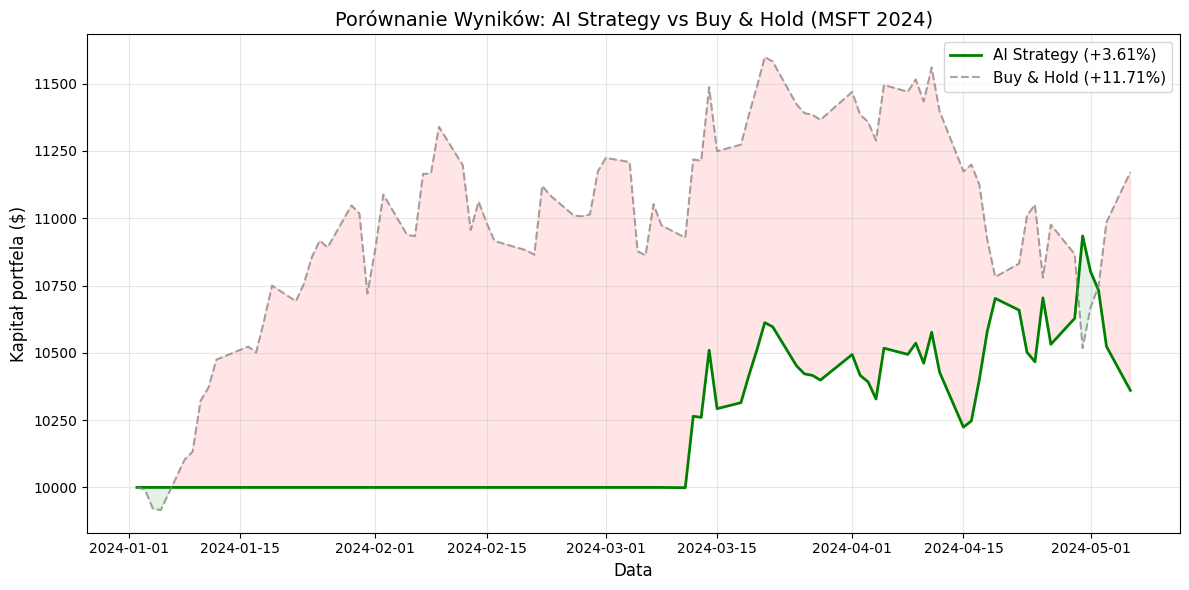


 RAPORT KOŃCOWY (01.01.2024 - 06.05.2024)
               Metryka Wartość
         Końcowy Zwrot   3.61%
     Liczba Transakcji       1
Skuteczność (Win Rate) 100.00%
          Max Drawdown  -5.25%
          Sharpe Ratio    0.68
--------------------------------------------------

INTERPRETACJA WYNIKU:
 NEGATYWNY: Strategia straciła do rynku 8.11 p.p.
   W silnym trendzie wzrostowym (hossa) trudniej pobić strategię Buy & Hold,
   ponieważ wyjścia na TP/SL ucinają potencjalne zyski z długich ruchów.

NAJLEPSZE PARAMETRY:
SmartTrendStrategy(n1=7,n2=26,n_trend=44,sl_pct=0.07,tp_pct=0.15,confidence_threshold=0.4)


In [5]:
# Przygotowanie danych do wykresu

# Krzywa kapitału strategii
equity_curve = stats._equity_curve['Equity']


initial_cash = 10000
# Normalizujemy cenę Close tak, aby startowała od 10,000 USD
bnh_equity = initial_cash * (bt_data['Close'] / bt_data['Close'].iloc[0])

# Obliczanie ostatecznych stóp zwrotu
strategy_return_pct = ((equity_curve.iloc[-1] - initial_cash) / initial_cash) * 100
bnh_return_pct = ((bnh_equity.iloc[-1] - initial_cash) / initial_cash) * 100
diff = strategy_return_pct - bnh_return_pct

#Generowanie wykresu

plt.figure(figsize=(12, 6))

# Linia Strategii AI
plt.plot(equity_curve.index, equity_curve, label=f'AI Strategy (+{strategy_return_pct:.2f}%)', color='green', linewidth=2)

# Linia Buy & Hold
plt.plot(bnh_equity.index, bnh_equity, label=f'Buy & Hold (+{bnh_return_pct:.2f}%)', color='gray', linestyle='--', alpha=0.7)

# Wypełnienie obszaru zysku/straty względem rynku
plt.fill_between(equity_curve.index, equity_curve, bnh_equity, where=(equity_curve > bnh_equity), color='green', alpha=0.1, interpolate=True)
plt.fill_between(equity_curve.index, equity_curve, bnh_equity, where=(equity_curve < bnh_equity), color='red', alpha=0.1, interpolate=True)

plt.title('Porównanie Wyników: AI Strategy vs Buy & Hold (MSFT 2024)', fontsize=14)
plt.ylabel('Kapitał portfela ($)', fontsize=12)
plt.xlabel('Data', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

# Wnioski

print("\n" + "="*50)
print(f" RAPORT KOŃCOWY (01.01.2024 - 06.05.2024)")
print("="*50)

# Tabela wyników
metrics = pd.DataFrame({
    'Metryka': ['Końcowy Zwrot', 'Liczba Transakcji', 'Skuteczność (Win Rate)', 'Max Drawdown', 'Sharpe Ratio'],
    'Wartość': [
        f"{stats['Return [%]']:.2f}%",
        f"{stats['# Trades']}",
        f"{stats['Win Rate [%]']:.2f}%",
        f"{stats['Max. Drawdown [%]']:.2f}%",
        f"{stats['Sharpe Ratio']:.2f}"
    ]
})
print(metrics.to_string(index=False))
print("-" * 50)

# Interpretacja wyniku
print("\nINTERPRETACJA WYNIKU:")
if diff > 0:
    print(f"POZYTYWNY: Strategia pobiła rynek o {diff:.2f} p.p.")
    print("Strategia okazała się lepsza niż pasywne trzymanie akcji.")
    if stats['Max. Drawdown [%]'] < 10:
        print("   Dodatkowo, strategia utrzymała relatywnie niskie ryzyko (Drawdown).")
else:
    print(f" NEGATYWNY: Strategia straciła do rynku {abs(diff):.2f} p.p.")
    print("   W silnym trendzie wzrostowym (hossa) trudniej pobić strategię Buy & Hold,")
    print("   ponieważ wyjścia na TP/SL ucinają potencjalne zyski z długich ruchów.")

print("\nNAJLEPSZE PARAMETRY:")
print(stats['_strategy'])

